## Model Selection using RFE (Bike Sharing Case Study)

Bike Sharing Assignement
Problem Statement
A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free.
The company want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands
Business Goal:
To model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features

### Importing and Understanding Data

In [184]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
#importig necessary libraries
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [185]:
# Importing day.csv and looking at first five rows
day=pd.read_csv("day.CSV")
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [186]:
day.shape
(730, 16)


(730, 16)

In [187]:
day.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

there are no missing data in the data set

In [188]:
day.workingday.value_counts()

1    504
0    226
Name: workingday, dtype: int64

In [189]:
day.holiday.value_counts()

0    709
1     21
Name: holiday, dtype: int64

### Data Preparation

In [190]:
# Converting 'weathersit' and 'season' column values 1,2,3,4 into string categorical values

day['season'] = day['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

day['weathersit'] = day['weathersit'].map({1:'Clear', 2:'Mist & Cloudy', 3:'Light Snow', 4:'Heavy Rain'})

# Converting 'mnth' column values 1 to 12 into Jan to Dec respectively

day['mnth'] = day['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})

In [191]:
# Converting 'yr' column values 0 and 1 into string 2018 and 2019 respectively

day['yr'] = day['yr'].map({0:'2018', 1:'2019'})

In [192]:
# Converting 'weekday' column  into string  values as Monday to Sunday

day['weekday'] = day['weekday'].map({1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 0:'Sunday'})


In [193]:
# dropping 'instant','dteday',"casual","registered" column since instant is just an index
# dropping atemp as temp col is quite pricese
# dropping dteday col as month, weeday, years are precisely given so no more required for the model


day = day.drop(['instant','dteday','casual','registered'], axis=1)

In [194]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,Jan,0,Monday,1,Mist & Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,0,Tuesday,1,Mist & Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,0,Wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,0,Thursday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,0,Friday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [195]:
day.shape
# now we have 11 colums left 

(730, 12)

In [196]:
day.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    object 
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 68.6+ KB


In [197]:
day.describe()
# getting the statistical summary 

,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.028767,0.690411,20.319259,23.726322,62.765175,12.763620,4508.006849
std,0.167266,0.462641,7.506729,8.150308,14.237589,5.195841,1936.011647
min,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


# Data Visualisation

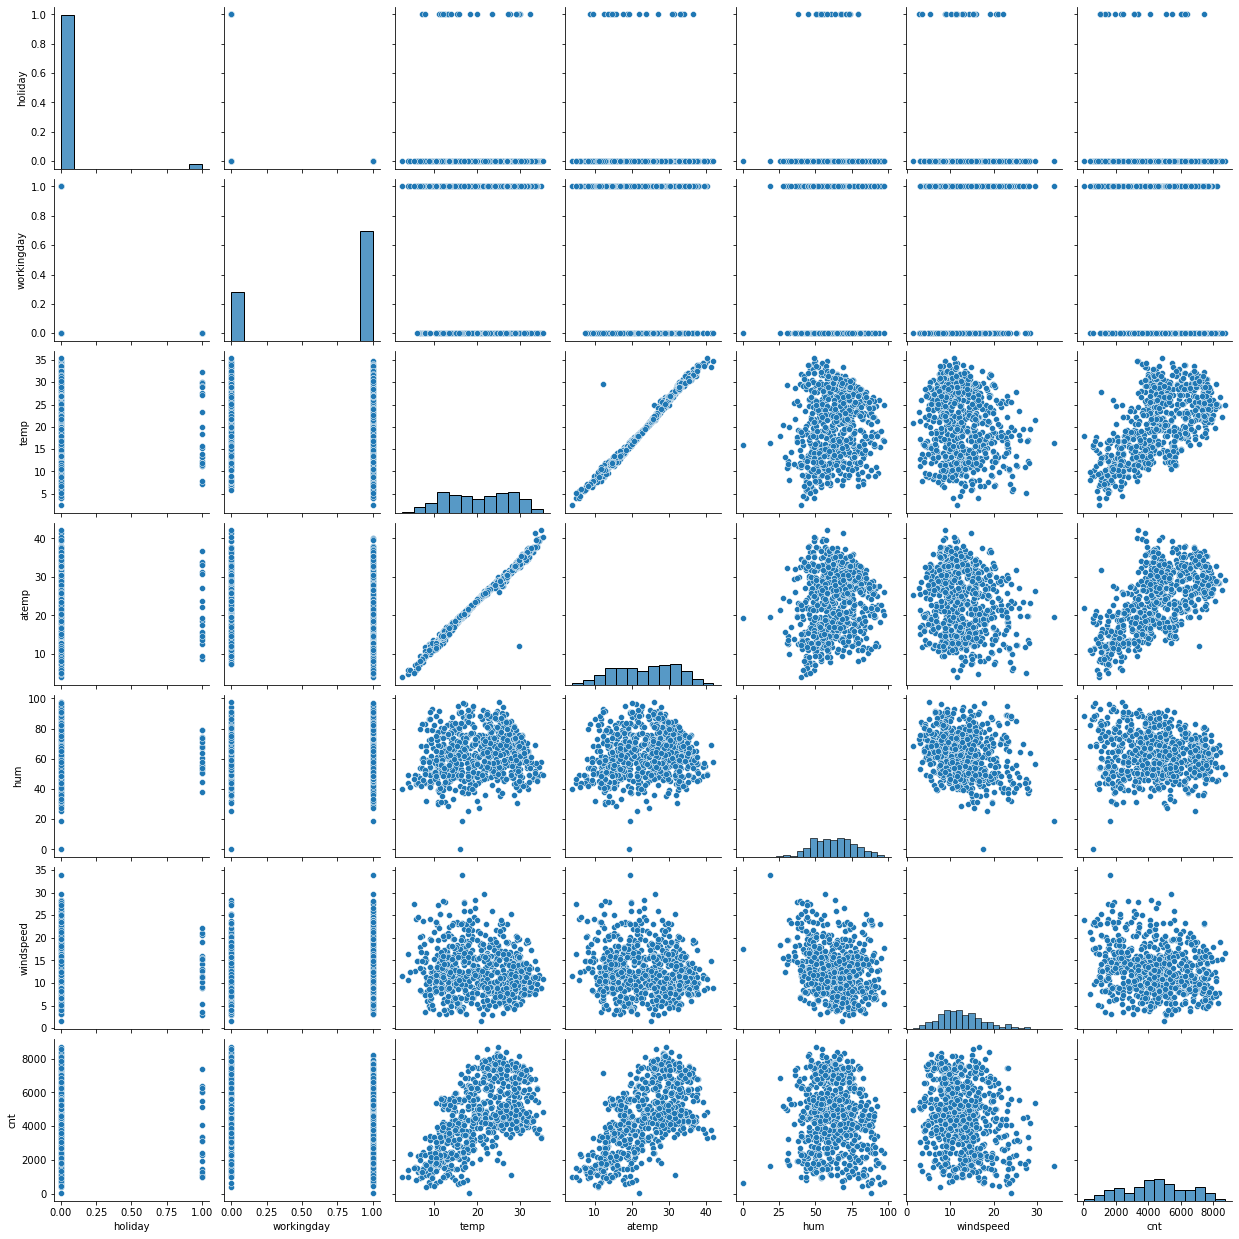

In [198]:
# plotting pair plots for the numeric variables
sns.pairplot(day)
plt.show()

<Figure size 1440x720 with 0 Axes>

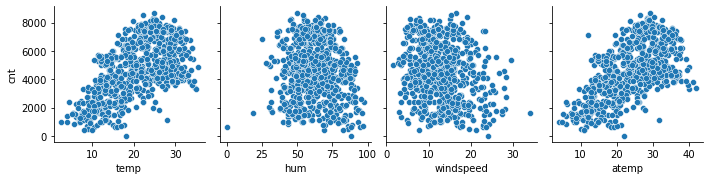

In [199]:
plt.figure(figsize=(20,10))
sns.pairplot(x_vars=['temp', 'hum', 'windspeed','atemp'], y_vars=['cnt'], data=day)
plt.show()

In [200]:
# from the above graph we observe that temp and atemp are highly correlated

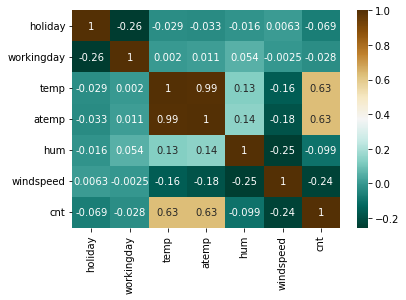

In [201]:
# visualising the correlation matrix for different variables
sns.heatmap(day.corr(), cmap="BrBG_r", annot = True)
plt.show()

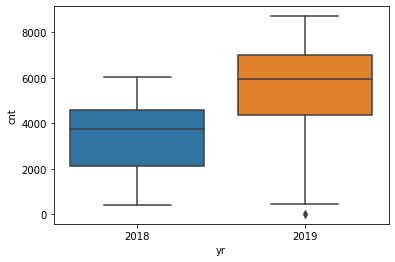

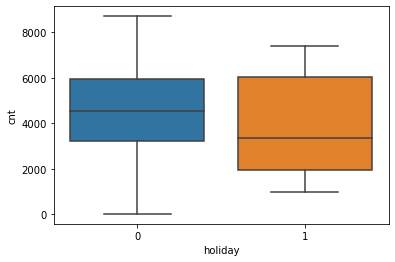

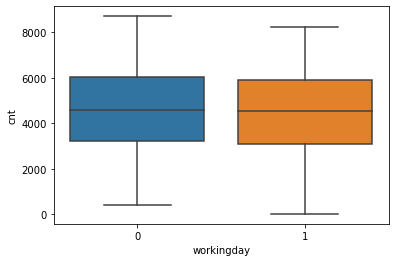

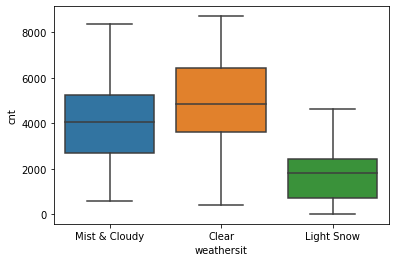

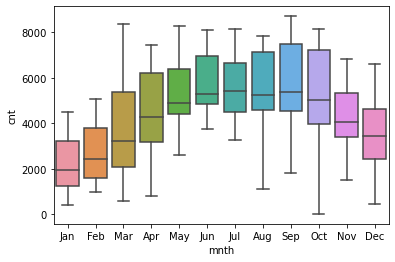

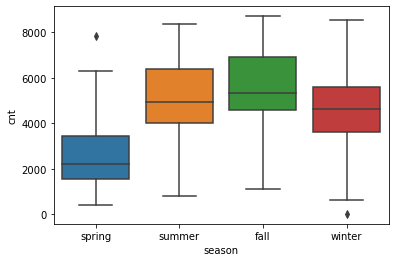

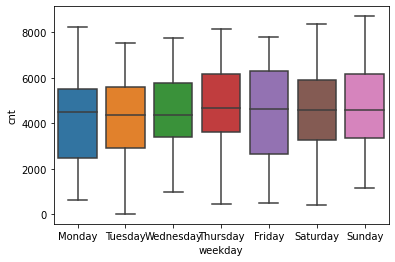

In [202]:

#visualising the categorical data with the help of boxplots
categorical = ["yr","holiday","workingday","weathersit","mnth","season","weekday"]
for i in categorical:
    
    sns.boxplot(x = i, y = 'cnt', data = day)
    plt.show()    

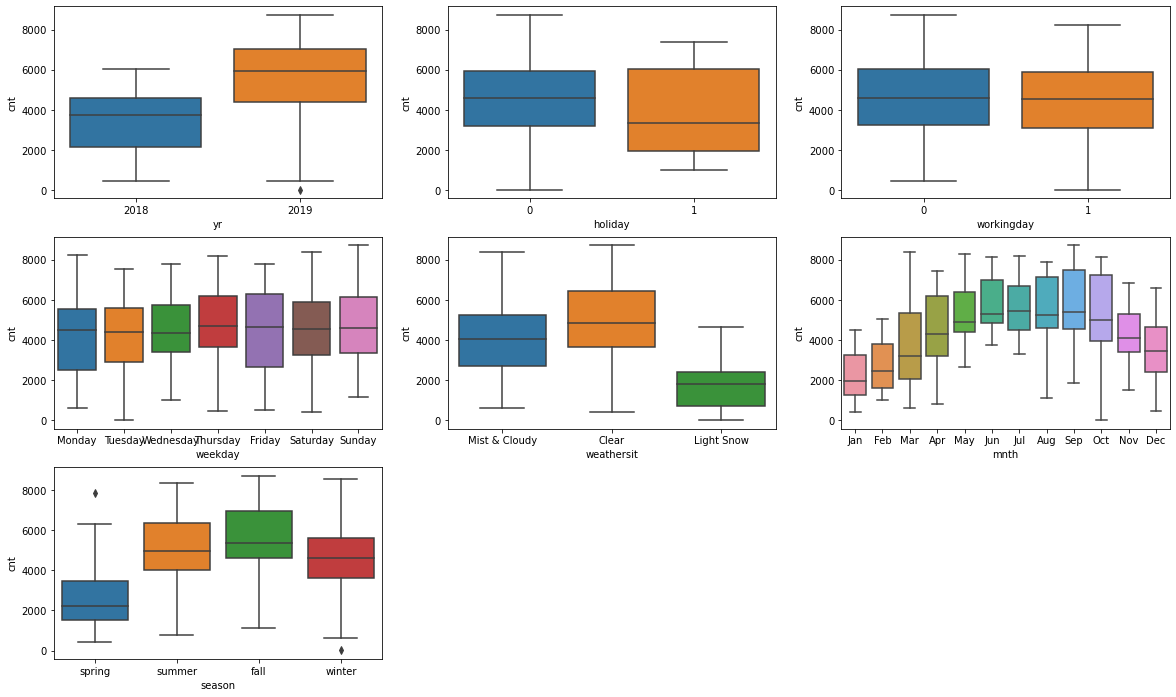

In [203]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'yr', y = 'cnt', data = day)
plt.subplot(3,3,2)
sns.boxplot(x = 'holiday', y = 'cnt', data = day)
plt.subplot(3,3,3)
sns.boxplot(x = 'workingday', y = 'cnt', data = day)
plt.subplot(3,3,4)
sns.boxplot(x = 'weekday', y = 'cnt', data = day)
plt.subplot(3,3,5)
sns.boxplot(x = 'weathersit', y = 'cnt', data = day)
plt.subplot(3,3,6)
sns.boxplot(x = 'mnth', y = 'cnt', data = day)
plt.subplot(3,3,7)
sns.boxplot(x = 'season', y = 'cnt', data = day)
plt.show()


### Dummy Variables

In [204]:











# Get the dummy variables for variable 'season' and store it in a new dataframe - 'season_dummy'
season_dummy = pd.get_dummies(day['season'])


In [205]:
# Check what the dataset 'season_dummy' looks like
season_dummy.head()


,fall,spring,summer,winter
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


Now, we don't need 4 columns. You can drop the fall column, as the type of season can be identified with just the last three columns where —
- 000 will correspond to fall
- 001 will correspond to winter
- 100 will correspond to spring
- 010 will correspond to summer


In [206]:
# Let's drop the first column from 'season_dummy'  using 'drop_first = True'

season_dummy = pd.get_dummies(day['season'], drop_first = True)

In [207]:
season_dummy.head(2)

,spring,summer,winter
0,1,0,0
1,1,0,0


In [208]:
# Add the results to the original 'day' dataframe

day = pd.concat([day, season_dummy], axis = 1)

In [209]:
# Now let's see the head of our dataframe.
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter
0,spring,2018,Jan,0,Monday,1,Mist & Cloudy,14.110847,18.18125,80.5833,10.749882,985,1,0,0
1,spring,2018,Jan,0,Tuesday,1,Mist & Cloudy,14.902598,17.68695,69.6087,16.652113,801,1,0,0
2,spring,2018,Jan,0,Wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,0
3,spring,2018,Jan,0,Thursday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,0
4,spring,2018,Jan,0,Friday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,0


In [210]:
# dropping the season column
day.drop(["season"], axis = 1, inplace = True)

In [211]:
day.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter
0,2018,Jan,0,Monday,1,Mist & Cloudy,14.110847,18.18125,80.5833,10.749882,985,1,0,0
1,2018,Jan,0,Tuesday,1,Mist & Cloudy,14.902598,17.68695,69.6087,16.652113,801,1,0,0
2,2018,Jan,0,Wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,0
3,2018,Jan,0,Thursday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,0
4,2018,Jan,0,Friday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,0


In [212]:
# Similarly get the dummy variables for the 'yr' categorical column and store it in a new dataframe - 'year_dummy'
year_dummy = pd.get_dummies(day['yr'])


In [213]:
#dropping the 1st column of the year_dummy
year_dummy = pd.get_dummies(day['yr'], drop_first = True)


In [214]:
# Add the results to the original 'day' dataframe
day = pd.concat([day, year_dummy], axis = 1)


In [215]:
# Drop 'yr' column as we have created the dummies for it
day.drop('yr', axis = 1, inplace = True)

In [216]:
day.head()

,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter,2019
0,Jan,0,Monday,1,Mist & Cloudy,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0
1,Jan,0,Tuesday,1,Mist & Cloudy,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0
2,Jan,0,Wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0
3,Jan,0,Thursday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0
4,Jan,0,Friday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0


In [217]:
# Similarly get the dummy variables for the 'mnth' categorical column and store it in a new dataframe - 'mnth_dummy'
mnth_dummy = pd.get_dummies(day['mnth'])


In [218]:
mnth_dummy.head(2)

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0


In [219]:
# Let's drop the first column from 'mnth_dummy' df using 'drop_first = True'
mnth_dummy = pd.get_dummies(day['mnth'], drop_first = True)


In [220]:
mnth_dummy.head(2)

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0


In [221]:
# Add the results to the original 'day' dataframe
day = pd.concat([day, mnth_dummy], axis = 1)


In [222]:
# Drop 'mnth' column as we have created the dummies for it
day.drop(['mnth'], axis = 1, inplace = True)

In [223]:
day.head()

,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,Monday,1,Mist & Cloudy,14.110847,18.18125,80.5833,10.749882,985,1,...,0,0,1,0,0,0,0,0,0,0
1,0,Tuesday,1,Mist & Cloudy,14.902598,17.68695,69.6087,16.652113,801,1,...,0,0,1,0,0,0,0,0,0,0
2,0,Wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,1,...,0,0,1,0,0,0,0,0,0,0
3,0,Thursday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,1,...,0,0,1,0,0,0,0,0,0,0
4,0,Friday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,1,...,0,0,1,0,0,0,0,0,0,0


In [224]:
# Similarly get the dummy variables for the 'weekday' categorical column and store it in a new dataframe - 'weekday_dummy'
weekday_dummy = pd.get_dummies(day['weekday'])


In [225]:
# Let's drop the first column from 'weekday_dummy' df using 'drop_first = True'
weekday_dummy = pd.get_dummies(day['weekday'], drop_first = True)


In [226]:
# Add the results to the original 'day' dataframe
day = pd.concat([day, weekday_dummy], axis = 1)


In [227]:
# Drop 'weekday' column as we have created the dummies for it
day.drop(['weekday'], axis = 1, inplace = True)


In [228]:
weekday_dummy.head()

,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,0


In [229]:
day.head()

,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,...,May,Nov,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,1,Mist & Cloudy,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,Mist & Cloudy,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
# Similarly get the dummy variables for the 'weathersit' categorical column and store it in a new dataframe - 'weathersit_dummy'
weathersit_dummy = pd.get_dummies(day['weathersit'])

In [231]:
weathersit_dummy.head(2)

,Clear,Light Snow,Mist & Cloudy
0,0,0,1
1,0,0,1


In [232]:
# Let's drop the first column from 'weathersit_dummy' df using 'drop_first = True'
weathersit_dummy = pd.get_dummies(day['weathersit'], drop_first = True)


In [233]:
# Add the results to the original 'day' dataframe
day = pd.concat([day, weathersit_dummy], axis = 1)


In [234]:
# Drop 'weathersit' column as we have created the dummies for it
day.drop(['weathersit'], axis = 1, inplace = True)

In [235]:
weathersit_dummy.head()

,Light Snow,Mist & Cloudy
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0


In [236]:
day.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light Snow,Mist & Cloudy
0,0,1,14.110847,18.18125,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,1,14.902598,17.68695,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
day.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light Snow,Mist & Cloudy
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,...,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.028767,0.690411,20.319259,23.726322,62.765175,12.763620,4508.006849,0.246575,0.252055,0.243836,...,0.084932,0.082192,0.143836,0.142466,0.142466,0.142466,0.143836,0.142466,0.028767,0.336986
std,0.167266,0.462641,7.506729,8.150308,14.237589,5.195841,1936.011647,0.431313,0.434490,0.429689,...,0.278971,0.274845,0.351164,0.349767,0.349767,0.349767,0.351164,0.349767,0.167266,0.473004
min,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Splitting the Data into Training and Testing Sets

In [238]:
#importing the necessary libraries
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively

df_train, df_test = train_test_split(day, train_size = 0.7, test_size = 0.3, random_state = 100)

### Rescaling the Features 

We will use MinMax scaling.

In [239]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [240]:
# Apply scaler() to all the columns except the 'categorical' and 'dummy' variables
num_vars = ['temp', 'hum', 'windspeed', 'cnt','atemp']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [241]:
df_train.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light Snow,Mist & Cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.025490,0.711765,0.537262,0.512989,0.650369,0.320768,0.513620,0.243137,0.245098,0.24902,...,0.086275,0.080392,0.154902,0.129412,0.137255,0.143137,0.152941,0.135294,0.029412,0.343137
std,0.157763,0.453386,0.225844,0.212385,0.145882,0.169797,0.224593,0.429398,0.430568,0.43287,...,0.281045,0.272166,0.362166,0.335985,0.344454,0.350557,0.360284,0.342373,0.169124,0.475223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [242]:
df_train.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light Snow,Mist & Cloudy
653,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,1,...,1,0,0,0,0,0,0,1,0,0
576,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,0,0,1,0,0
426,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,...,0,0,0,0,1,0,0,0,0,1
728,0,1,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,...,0,0,1,0,0,0,0,0,0,0
482,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,...,0,0,0,0,1,0,0,0,0,1


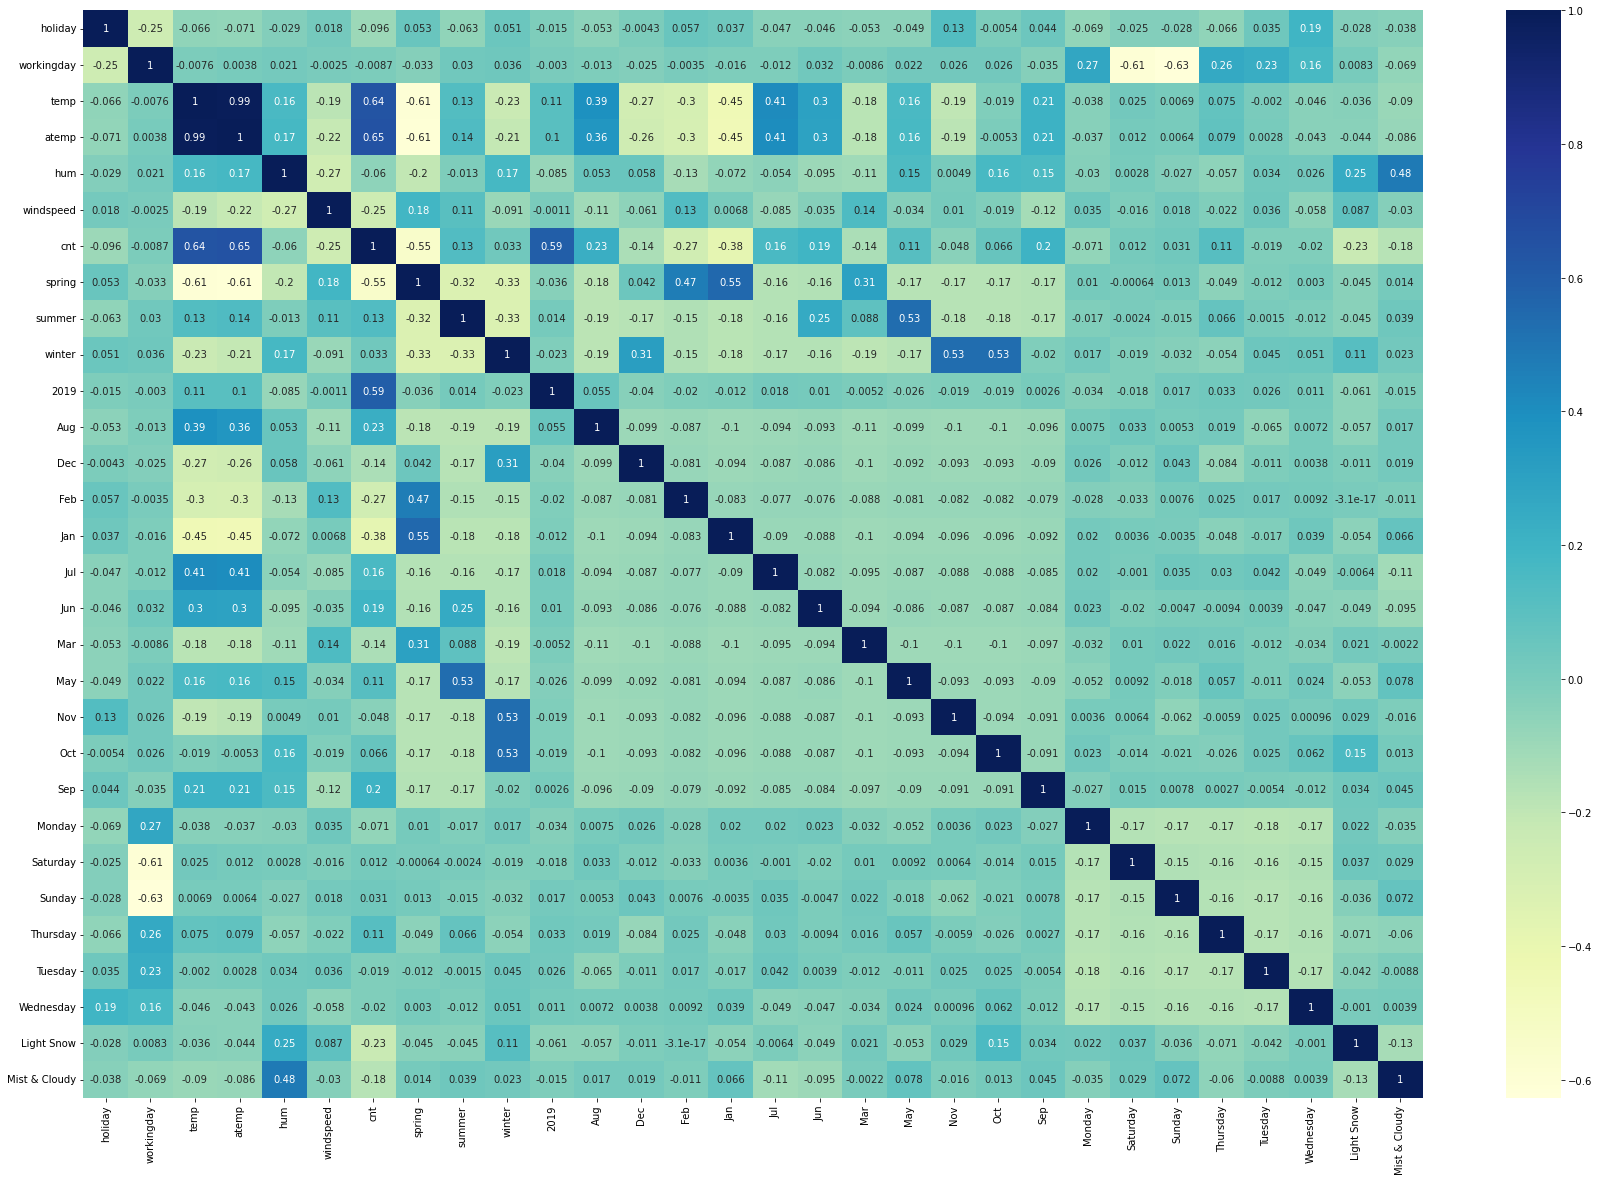

In [243]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (30, 20))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()


In [244]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 653 to 79
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   holiday        510 non-null    int64  
 1   workingday     510 non-null    int64  
 2   temp           510 non-null    float64
 3   atemp          510 non-null    float64
 4   hum            510 non-null    float64
 5   windspeed      510 non-null    float64
 6   cnt            510 non-null    float64
 7   spring         510 non-null    uint8  
 8   summer         510 non-null    uint8  
 9   winter         510 non-null    uint8  
 10  2019           510 non-null    uint8  
 11  Aug            510 non-null    uint8  
 12  Dec            510 non-null    uint8  
 13  Feb            510 non-null    uint8  
 14  Jan            510 non-null    uint8  
 15  Jul            510 non-null    uint8  
 16  Jun            510 non-null    uint8  
 17  Mar            510 non-null    uint8  
 18  May      

### Dividing into X and Y sets for the model building

In [245]:
y_train=df_train.pop('cnt')
X_train=df_train

In [246]:
X_train.shape

(510, 29)

## Building our model

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

### RFE
Recursive feature elimination

In [247]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [248]:
# Running RFE with the output number of the variable equal to 14
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(estimator= lm, n_features_to_select=15)            # running RFE
rfe = rfe.fit(X_train, y_train)

In [249]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', False, 3),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('2019', True, 1),
 ('Aug', False, 10),
 ('Dec', True, 1),
 ('Feb', False, 2),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 14),
 ('Mar', False, 15),
 ('May', False, 7),
 ('Nov', True, 1),
 ('Oct', False, 12),
 ('Sep', True, 1),
 ('Monday', False, 9),
 ('Saturday', False, 4),
 ('Sunday', False, 5),
 ('Thursday', False, 13),
 ('Tuesday', False, 8),
 ('Wednesday', False, 11),
 ('Light Snow', True, 1),
 ('Mist & Cloudy', True, 1)]

In [250]:
col = X_train.columns[rfe.support_]
col


Index(['holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter',
       '2019', 'Dec', 'Jan', 'Jul', 'Nov', 'Sep', 'Light Snow',
       'Mist & Cloudy'],
      dtype='object')

In [251]:
len(col)

15

In [253]:
X_train.columns[~rfe.support_]


Index(['workingday', 'atemp', 'Aug', 'Feb', 'Jun', 'Mar', 'May', 'Oct',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics

In [254]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]


In [255]:
X_train_rfe.head()

,holiday,temp,hum,windspeed,spring,summer,winter,2019,Dec,Jan,Jul,Nov,Sep,Light Snow,Mist & Cloudy
653,0,0.509887,0.575354,0.300794,0,0,1,1,0,0,0,0,0,0,0
576,0,0.815169,0.725633,0.264686,0,0,0,1,0,0,1,0,0,0,0
426,0,0.442393,0.640189,0.255342,1,0,0,1,0,0,0,0,0,0,1
728,0,0.245101,0.498067,0.663106,1,0,0,1,1,0,0,0,0,0,0
482,0,0.395666,0.504508,0.188475,0,1,0,1,0,0,0,0,0,0,1


In [268]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

In [269]:
lm = sm.OLS(y_train,X_train_rfe).fit()

In [270]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     180.2
Date:                Mon, 09 Jan 2023   Prob (F-statistic):          3.34e-189
Time:                        23:59:53   Log-Likelihood:                 514.72
No. Observations:                 510   AIC:                            -997.4
Df Residuals:                     494   BIC:                            -929.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3202      0.036      8.886

In [271]:
X_train_new = X_train_rfe.drop(['const'], axis=1)

In [278]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,temp,5.17
2,windspeed,4.67
5,winter,2.94
3,spring,2.89
4,summer,2.23
6,2019,2.07
10,Nov,1.80
8,Jan,1.66
9,Jul,1.59
13,Mist & Cloudy,1.56


In [273]:
# Since 'nov' has high P value  , removing straintaway

X_train_new = X_train_new.drop(['hum'], axis=1)

In [274]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [275]:
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model

In [277]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     185.4
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          1.57e-186
Time:                        00:00:34   Log-Likelihood:                 505.61
No. Observations:                 510   AIC:                            -981.2
Df Residuals:                     495   BIC:                            -917.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2466      0.032      7.679      0.000       0.184       0.310
holiday          -0.0919      0.026     -3.533      0.000      -0.143      -0.041
temp              0.4377      0.036     12.083      0.000       0.366       0.509
windspeed        -0.1586      0.025     -6.290      0.000      -0.208      -0.109
spring           -0.0716      0.021     -3.337      0.001      -0.114      -0.029
summer            0.0333      0.015      2.148      0.032       0.003       0.064
winter            0.0887      0.018      4.951      0.000       0.053       0.124
2019              0.2343      0.008     28.709      0.000       0.218       0.250
Dec              -0.0445      0.018     -2.520      0.012      -0.079      -0.010
Jan              -0.0503      0.018     -2.738      0.006      -0.086      -0.014
Jul              -0.0504      0.018     -2.725      0.007      -0.087      -0.014
Nov              -0.0419      0.019     -2.198      0.028      -0.079      -0.004
Sep               0.0682      0.017      3.992      0.000       0.035       0.102
Light Snow       -0.2929      0.025    -11.908      0.000      -0.341      -0.245
Mist & Cloudy    -0.0814      0.009     -9.359      0.000      -0.099      -0.064
==============================================================================
Omnibus:                       70.031   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.566
Skew:                          -0.702   Prob(JB):                     7.52e-39
Kurtosis:                       5.508   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
X_train_new = X_train_new.drop(['const'], axis=1)

KeyError: "['const'] not found in axis"

In [ ]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

In [344]:
# Dropping 'const' 
X_train_new = X_train_new.drop(['const'], axis=1)

In [345]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,hum,28.06
1,temp,16.02
3,windspeed,4.65
4,spring,4.01
6,winter,3.35
5,summer,2.78
11,Mist & Cloudy,2.28
7,2019,2.08
8,Jul,1.58
9,Sep,1.38


Rebuilding the model without `jan`

In [347]:
X_train_new = X_train_new.drop(['hum'], axis=1)

In [349]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [350]:
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model

In [351]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.4
Date:                Mon, 09 Jan 2023   Prob (F-statistic):          2.40e-187
Time:                        13:49:06   Log-Likelihood:                 499.17
No. Observations:                 510   AIC:                            -974.3
Df Residuals:                     498   BIC:                            -923.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1996      0.030      6.758      0.000       0.142       0.258
holiday          -0.0980      0.026     -3.761      0.000      -0.149      -0.047
temp              0.4915      0.033     14.798      0.000       0.426       0.557
windspeed        -0.1480      0.025     -5.893      0.000      -0.197      -0.099
spring           -0.0669      0.021     -3.167      0.002      -0.108      -0.025
summer            0.0453      0.015      2.971      0.003       0.015       0.075
winter            0.0831      0.017      4.818      0.000       0.049       0.117
2019              0.2335      0.008     28.361      0.000       0.217       0.250
Jul              -0.0524      0.019     -2.811      0.005      -0.089      -0.016
Sep               0.0767      0.017      4.511      0.000       0.043       0.110
Light Snow       -0.2852      0.025    -11.536      0.000      -0.334      -0.237
Mist & Cloudy    -0.0816      0.009     -9.301      0.000      -0.099      -0.064
==============================================================================
Omnibus:                       59.298   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.189
Skew:                          -0.628   Prob(JB):                     4.41e-30
Kurtosis:                       5.187   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [352]:
# Dropping 'const' 
X_train_new = X_train_new.drop(['const'], axis=1)

KeyError: "['const'] not found in axis"

In [353]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,temp,5.09
2,windspeed,4.60
4,summer,2.21
3,spring,2.08
6,2019,2.07
5,winter,1.79
7,Jul,1.58
10,Mist & Cloudy,1.55
8,Sep,1.34
9,Light Snow,1.08


In [354]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_lm = sm.add_constant(X_train_new)

In [355]:
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model

In [356]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.4
Date:                Mon, 09 Jan 2023   Prob (F-statistic):          2.40e-187
Time:                        13:50:55   Log-Likelihood:                 499.17
No. Observations:                 510   AIC:                            -974.3
Df Residuals:                     498   BIC:                            -923.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1996      0.030      6.758

In [85]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,hum,28.06
1,temp,16.02
3,windspeed,4.65
4,spring,4.01
6,winter,3.35
5,summer,2.78
11,Mist & Cloudy,2.28
7,2019,2.08
8,Jul,1.58
9,Sep,1.38


We could have :

High P value and High VIF (Remove straighaway)
-High-low - High P , low VIF (Remove these first) - Low P, high VIF (Remove after the above once are removed)

Low P Low VIF (Keep these varaibales)

In [86]:
# Since 'hum' has high vif, removing 

X_train_new = X_train_new.drop(['hum'], axis=1)

In [87]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [88]:
lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model

In [89]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.4
Date:                Mon, 09 Jan 2023   Prob (F-statistic):          2.40e-187
Time:                        13:33:03   Log-Likelihood:                 499.17
No. Observations:                 510   AIC:                            -974.3
Df Residuals:                     498   BIC:                            -923.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1996      0.030      6.758

In [90]:
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,temp,5.09
2,windspeed,4.60
4,summer,2.21
3,spring,2.08
6,2019,2.07
5,winter,1.79
7,Jul,1.58
10,Mist & Cloudy,1.55
8,Sep,1.34
9,Light Snow,1.08


## Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [662]:
y_train_pred = lm.predict(X_train_lm)

Text(0.5, 0, 'Errors')

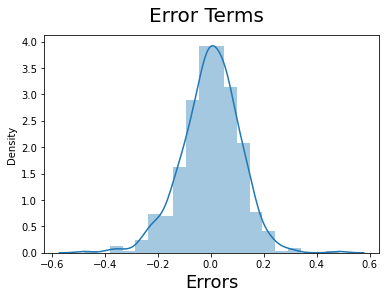

In [663]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

## Making Predictions

#### Applying the scaling on the test sets

In [664]:
num_vars =  ['temp', 'hum', 'windspeed', 'cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])

### dividing the test data set into ytest and x test

In [665]:
df_test.head(2)

,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,2019,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light Snow,Mist & Cloudy
184,1,0,0.831783,0.657364,0.084219,0.692706,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,0,1,0.901354,0.610133,0.153728,0.712034,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


In [666]:
y_test = df_test.pop('cnt')
X_test = df_test

In [667]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new_sm = sm.add_constant(X_test_new)

In [668]:
X_test_new_sm.columns

Index(['const', 'holiday', 'windspeed', 'spring', 'summer', 'winter', '2019',
       'Sep', 'Light Snow', 'Mist & Cloudy'],
      dtype='object')

In [669]:
# Making predictions
y_pred = lm.predict(X_test_new_sm)

Text(0, 0.5, 'y_pred')

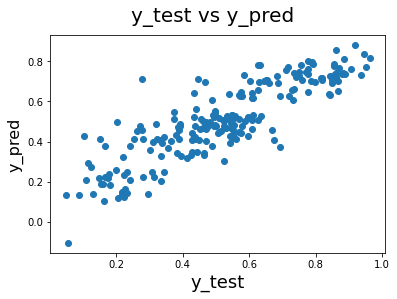

In [670]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                    

In [671]:
from sklearn.metrics import r2_score
r2_score(y_true=y_test, y_pred=y_pred)

0.7412090812945695

##### We have seen that the R2 score on training set was 0.763 and on the test set it is 0.741
Looking at the r2_score we can say that, what the model has learnt in the training set; it is also able to generalise on the test set.

In [672]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     179.2
Date:                Mon, 09 Jan 2023   Prob (F-statistic):          2.74e-150
Time:                        01:30:50   Log-Likelihood:                 406.06
No. Observations:                 510   AIC:                            -792.1
Df Residuals:                     500   BIC:                            -749.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5795      0.015     39.516

In [673]:
lm.params

const            0.579505
holiday         -0.100770
windspeed       -0.170504
spring          -0.295903
summer          -0.041662
winter          -0.073646
2019             0.247224
Sep              0.076163
Light Snow      -0.297098
Mist & Cloudy   -0.090530
dtype: float64

In [674]:
lm.params.sort_values(ascending = False)

const            0.579505
2019             0.247224
Sep              0.076163
summer          -0.041662
winter          -0.073646
Mist & Cloudy   -0.090530
holiday         -0.100770
windspeed       -0.170504
spring          -0.295903
Light Snow      -0.297098
dtype: float64

### the model that the company can predict the demand for shared bikes with the available independent variable

cnt = (-0.100770) * holiday + ( -0.170504) * windspeed + (-0.295903) * spring + (-0.041662) * summer + (-0.073646) * winter + (0.247224) * 2019  + 0.076163 * sep + (-0.297098) * light snow + (-0.090530) * mist & cloudy +  0.579505


### this equation can be used by the management to understand how exactly the demands vary with different features